# Interactive Julia for *Proximally Guided Stochastic Subgradient Method for Nonsmooth, Nonconvex Problems* #

### Benjamin Grimmer and Damek Davis ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/1707.03505). Its purpose is to give a simple and understandable implementation of the algorithms and concepts therein. Throughout this document, we will provide references to equations, lemmas, and theorems using the numbering given in that paper. 

The general outline of this document is the following:

1. Implementation of Basic Definitions and Algorithms
2. Solving a Few Toy Problems
3. Solving a Real Problem - Robust PCA

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give the simplest implementation possible. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and parallelization schemes.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*.

[1] "Proximally Guided Stochastic Subgradient Method for Nonsmooth, Nonconvex Problems", https://arxiv.org/abs/1707.03505. Benjamin Grimmer, Damek Davis. First posted July 12th, 2017.

# Implementation of Basic Definitions and Algorithms #

We consider the problem of minimizing a nonconvex, nonsmooth function $\phi(x)$ over a convex set $C$:

$$ \min_{x\in C} \phi(x).$$

We make two primary assumptions on the function $\phi$.
* $\phi(x)$ is Lipschitz continuous (as is commonly assumed by subgradient methods, except entirely avoided by the recent works [here](https://arxiv.org/abs/1703.09280) and [here](https://doi.org/10.1137/15M1027371))
* $\phi(x) + (\rho/2) \|x\|^2$ is convex for some $\rho>0$. This is commonly known as weak convexity and corresponds to the function having at most quadratic decrease. Common classes of nonconvex problems like additive composite and convex composite satisfy this condition. 

Since this problem is nonsmooth, we need to generalize the notion of a gradient to subgradients. There are many different definitions of subgradients for nonconvex problems (e.g., Frechet, Clarke, Limiting, ...), but under our regularity assumptions, these are all equivalent. These are defined in Section 2.1. We denote the subdifferential of $\phi(x)$ by $\partial \phi(x)$. Then our goal is to find a stationary point, that is

$$ x\in C \text{ such that } 0\in\partial\phi(x) + N_C(x)$$

where $N_C(x)$ is the set of normal vectors of $C$ at $x$.

We don't assume we have access to $\partial \phi(x)$, but rather an unbiased stochastic oracle for it.
To illistrate this structure, we begin by defining two example problems.

#### Example 1 - Regression with Sparse Regularizer ####
$$\min_{x\in R^{n}} \|Ax - b\|^2_2 + \|x\|_1 = \sum_{i=1}^m (a_i^T x - b_i)^2 + \|x\|_1$$

In [1]:
n,m = 10,20
A = randn(m,n)
b = randn(m)

"The objective function"
function obj_RegressionWithSparseRegularizer(x)
    norm(A*x-b)^2 + norm(x,1)
end

"Subgradient of the one norm"
function subgrad_norm1(x)
    sign(x)
end

"An element of the true subdifferential"
function subgrad_RegressionWithSparseRegularizer(x)
    2*A'*(A*x-b) + subgrad_norm1(x)
end

"A stochastically generated estimate of a subgradient"
function oracle_RegressionWithSparseRegularizer(x)
    i = rand(1:m)
    2*A[i,:]*((A[i,:]'*x-b[i])[1]) + subgrad_norm1(x)
end;

#### Example 2 - Minimizing General Constrained Quadratics ####
We consider the following simple constrained problem.
$$ \min_{\|x\|_2 \leq 1} x^T H x = \sum_{i,j} H_{i,j}x_ix_j$$

In [2]:
H = randn(n,n)

"The objective function"
function obj_Quadratic(x)
    (x'*H*x)[1]
end

"Projection onto the Feasible Region"
function projection_Quadratic(x)
    if(norm(x)>1) x/norm(x)
    else x
    end
end

"An element of the true subdifferential"
function subgrad_Quadratic(x)
    2*H*x
end

"A stochastically generated estimate of a subgradient"
function oracle_Quadratic(x)
    i = rand(1:n)
    j = rand(1:n)
    g = zeros(n)
    g[i] += H[i,j]*x[j]
    g[j] += H[i,j]*x[i]
    return g
end;

### The PGSG Algorithm ###

The PGSG Algorithm (defined as Algorithm 1 in [[1]](https://arxiv.org/abs/1707.03505)) aims to compute an approximate stationary point by inexactly solving a proximal step at each iteration. Formally the proximal step is given by

$$ \mathbf{prox}_{\gamma\phi}(x) = \mathrm{argmin}_{y\in C}\{\phi(y) + \frac{1}{2\gamma}\|y-x\|^2\}.$$

This subproblem is intractable in general, so we only solve it approximately using a stochastic subgradient method. For a given $x$ and $\gamma$, subgradients of this subproblem are given by

$$ \partial\left(\phi(\cdot) + \frac{1}{2\gamma}\|\cdot - x\|^2\right)(y) = \partial \phi(y) + \frac{1}{\gamma}(y-x).$$

Then the subroutine for solving this inner problem is very simple (assuming we are given functions for computing how many iterations to do and what step sizes to use, referred to below as `innerStepCount()` and `innerStepSize()`). We iteratively take stochastic subgradient steps and then finally return the average of all of our iterates.

In [3]:
"Subroutine for solving proximal step from x of size γ.
Each iteration uses the above subgradient formula and the orthgonally projects on to the feasible region.
Output is the average of all iterates."
function inexactProx(x, γ, oracle_phi, projection, innerStepCount, innerStepSize)
    y = x #Current Iterate
    w = x #Average of all Iterates
    for j in 1:innerStepCount()
        g = oracle_phi(y) + (y-x)/γ    #Compute Stochastic Subgradient of Proximal Subproblem
        y = projection(y - innerStepSize(j)*g)     #Do a stochastic projected subgradient step
        w = (j*w + y)/(j+1)            #Update Running average
    end
    return w
end;

Given this subroutine, the PGSG algorithm is very easy to state. We just iteratively apply this routine with proper selection of inner step counts, inner step sizes, and the value of $\gamma$. The regularity conditions we assume on $\phi(x)$ provide us with a weak convexity parameter $\rho>0$, which we assume is known (although Section 3.2 considers a variation of this algorithm that avoids assuming such knowledge). Then we use the following selections for these values (although these could (and probably should) certainly be tuned for a particular application to get best performance), where $t$ denotes the number of outer iterations we have done.

$$ \gamma = \frac{1}{2\rho}$$
$$ innerStepCount(t) = t + 1$$
$$ innerStepSize(j) = \frac{2}{\rho(j+49)}$$

Then the implementation of PGSG is the following

In [4]:
"Proximally Guided Subgradient Method using above above selection for constants."
function PGSG(x0, ρ, T, oracle_phi, projection)
    γ=1/(2*ρ)
    x = x0
    for t in 1:T
        #Define how to solve our our proximal subproblem
        function innerStepCount()
            return t+1
        end
        function innerStepSize(j)
            return 2/(ρ*(j+49))
        end
        
        #Inexactly solve the proximal step
        x = inexactProx(x, γ, oracle_phi, projection, innerStepCount, innerStepSize)
    end
    return x
end;

# Solving a Few Toy Problems #

Now we are equipt with enough code to solve our pair of simple toy problems presented above in examples 1 and 2.

#### Solving Regression with Sparse Regularizer ####
We begin by solving the simple regularized regression problem. This problem happens to be convex, so our parameter $\rho=0$, but the algorithm will work with any upper bound of $\rho$. So to avoid a division by zero error (without modifying the code), we will use $\rho=1$.

In [5]:
x0 = rand(n)
sol = PGSG(x0, 1.0, 100, oracle_RegressionWithSparseRegularizer, identity)

println("Initial Objective Value: ", obj_RegressionWithSparseRegularizer(x0))
println("Final Objective Value:   ", obj_RegressionWithSparseRegularizer(sol));

Initial Objective Value: 68.39146029828268
Final Objective Value:   26.383936718214752


To see how quickly this is converging, we plot the objective value produced by running the algorithm for various numbers of outer iterations. To do so, we need to define a version of PGSG which will track the objective value while the algorithm runs: 

In [6]:
using DataStructures
"Identical to the previous inexactProx, except it builds a list of objective values at w while it runs"
function inexactProx_objectiveTracking(x, γ, oracle_phi, projection, innerStepCount, innerStepSize, obj_phi, obj_list)
    y = x #Current Iterate
    w = x #Average of all Iterates
    for j in 1:innerStepCount()
        g = oracle_phi(y) + (y-x)/γ    #Compute Stochastic Subgradient of Proximal Subproblem
        y = projection(y - innerStepSize(j)*g)     #Do a stochastic projected subgradient step
        w = (j*w + y)/(j+1)            #Update Running average
        
        curObj = obj_phi(w)
        obj_list = cons(curObj, obj_list)
    end
    return w, obj_list
end
"Identical to the previous PGSG, except it builds a list of objective values from each inner loop"
function PGSG_objectiveTracking(x0, ρ, T, oracle_phi, projection, obj_phi)
    obj_list = nil()
    γ=1/(2*ρ)
    x = x0
    for t in 1:T
        #Define how to solve our our proximal subproblem
        function innerStepCount()
            return t+1
        end
        function innerStepSize(j)
            return 2/(ρ*(j+49))
        end
        
        #Inexactly solve the proximal step
        x, obj_list = inexactProx_objectiveTracking(x, γ, oracle_phi, projection, innerStepCount, innerStepSize, obj_phi, obj_list)
    end
    return x, obj_list
end;

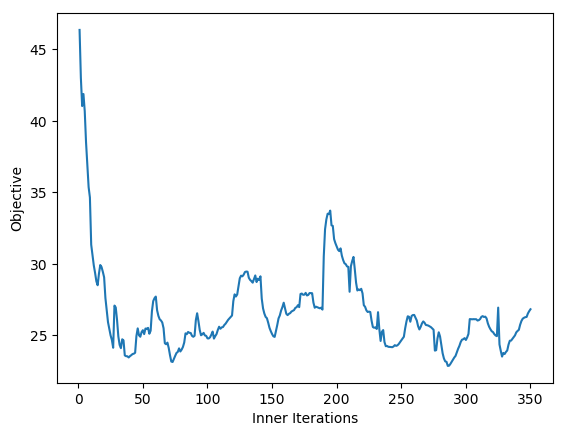

In [7]:
x0 = rand(n)
sol, obj_list = PGSG_objectiveTracking(x0, 1.0, 25, oracle_RegressionWithSparseRegularizer, identity, obj_RegressionWithSparseRegularizer)

#The objective list here is in reverse order, so we will reverse it and then plot it.
obj = zeros(length(obj_list))
i=0
for val in obj_list
    obj[length(obj_list)-i] = val
    i = i+1
end    
using PyPlot
plot(1:length(obj_list), obj)
xlabel("Inner Iterations")
ylabel("Objective");

#### Solving General Constrained Quadratics  ####
Now we solve our second toy problem given in Example 2 above. Unlike our previous example, this problem is nonconvex. One can easily verify that this satisfies our regularity conditions with paramter $\rho = \|H\|_F$

In [8]:
x0 = rand(n)
sol = PGSG(x0, 1.0, 100, oracle_Quadratic, projection_Quadratic)

println("Initial Objective Value: ", obj_RegressionWithSparseRegularizer(x0))
println("Final Objective Value:   ", obj_RegressionWithSparseRegularizer(sol));

Initial Objective Value: 53.36267138172181
Final Objective Value:   37.44880898443584


Using our above code that tracks the objective value when PGSG runs, we see that this method is also quickly converging.

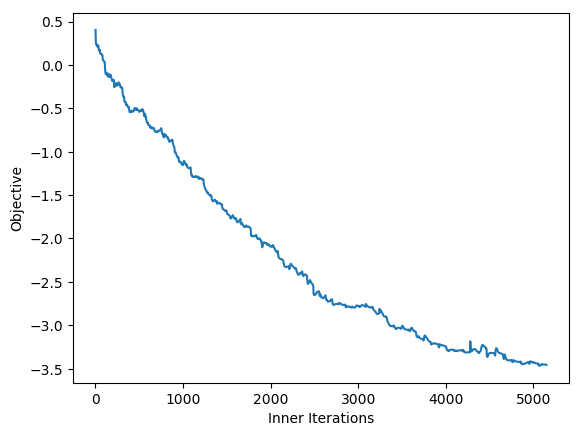

In [9]:
x0 = rand(n)
sol, obj_list = PGSG_objectiveTracking(x0, 1.0, 100, oracle_Quadratic, projection_Quadratic, obj_Quadratic)

#The objective list here is in reverse order, so we will reverse it and then plot it.
obj = zeros(length(obj_list))
i=0
for val in obj_list
    obj[length(obj_list)-i] = val
    i = i+1
end    
using PyPlot
plot(1:length(obj_list), obj)
xlabel("Inner Iterations")
ylabel("Objective");

# Solving a Real Problem - Robust PCA #

In Section 5 of [[1]](https://arxiv.org/abs/1707.03505), we consider solving a computer vision problem using a matrix factorization problem. We'll briefly sketch the problem here (see the paper for a more detailed description).

Our goal is to separate the foreground and background from a series of images. We consider a dataset of 102 images. The first 100 are pictures of trees on the side of a road (with minor differences among eah other from the trees rustling). Then we are given two pictures which have a truck driving through the seen. Then we aim to separate these two parts of the image using a matrix factorization.

For each image, we vectorize it (and convert to greyscale). These column vectors are combined together to form our data matrix $A\in \mathbb{R}^{20480 \times 102}$. Then we compute a low rank (in this case, rank 10) model of $A$ with a sparse error pattern from $A$. We can reasonably interpret the low rank model as the background since it captures the commonality of all of the images, whereas the sparse error pattern will correspond to the object in the foreground. As a optimization problem this means we will minimize

$$\min_{U\in\mathbb{R}^{10\times 20480},V\in\mathbb{R}^{10\times 102}} \phi(U,V) = \|U^TV - A\|_1 = \frac{1}{102}\sum^{102}_{j=1} \|U^TV_j - A_{j}\|_1 = \frac{1}{nm} \sum_{i,j} |U_i^TV_j - A_{i,j}|$$

For each of our subgradient evaluations, we will select a single frame from our dataset and compute an estimate of the subgradient from it. An implementation of this is given below.

#### Defining Objective Function and Subgradient Oracle ####

In [10]:
"The objective function"
function obj_RPCA(X)
    return vecnorm(X[1].'*X[2] - A,1)
end

"Stochastic oracle that generates an unbiased estimator of a subgradient by considering a single frame of the image"
function oracle_RPCA(X)
    U,V = X[1],X[2]        
    n,m = size(U)
    n,k = size(V)
    ∇U = zeros(n,m)
    ∇V = zeros(n,k)       
    for i in 1:m #iterate over pixels
        j = rand(1:k) #random over frames
            if (U[:,i]'V[:,j])[1] - A[i,j]>0.001
                for l in 1:n #iterate over components
                    ∇U[l,i] = ∇U[l,i] + V[l,j]
                    ∇V[l,j] = ∇V[l,j] + U[l,i]
                end
            end
            if (U[:,i]'V[:,j])[1] - A[i,j]<-0.001
                for l in 1:n #iterate over components
                    ∇U[l,i] = ∇U[l,i] - V[l,j]
                    ∇V[l,j] = ∇V[l,j] - U[l,i]
                end
            end
    end
    return [∇U, ∇V]*0.1 #Multiplying subgradient size by a tuning constant to improve performance
end;

#### Reading in the data ####

In [11]:
##### load data #####
n,m = 20480, 102;
fid = open("./data/trees.bin","r")
A   = read(fid, UInt8, n*m)
A   = reshape(A, n, m)
close(fid)

A   = A/255

##### set up parameters #####
k   = 10; #number of componets in low rank model

# svd initialization
UΣV,nconv,niter,nmult,resid = svds(A,nsv=k,tol=1e-12)
U   = diagm(sqrt(UΣV[:S]))*UΣV[:U].';
V   = diagm(sqrt(UΣV[:S]))*UΣV[:V];
for I in eachindex(U)
    U[I] < 0.0 ? U[I] = 0.0 :
    U[I] > 1.0 ? U[I] = 1.0 : continue
end
for I in eachindex(V)
    V[I] < 0.0 ? V[I] = 0.0 :
    V[I] > 1.0 ? V[I] = 1.0 : continue
end;

#### Solve the Problem ####

In [12]:
sol = PGSG([U,V], 2.0, 25, oracle_RPCA, identity); 

println("Initial Objective Value: ", obj_RPCA([U,V]))
println("Final Objective Value:   ", obj_RPCA(sol));

Initial Objective Value: 920406.9216872506
Final Objective Value:   69164.1581978105


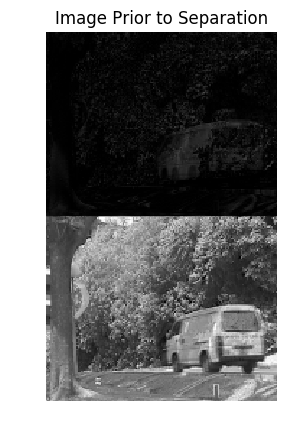

In [13]:
"Generates a pretty picture of the foreground/background separation given by a factorization U, V"
function separate(U,V)
    L = U'*V;
    R = A - L;
    for I in eachindex(L)
        L[I] < 0.0 ? L[I] = 0.0 :
        L[I] > 1.0 ? L[I] = 1.0 : continue
    end
    for I in eachindex(L)
        R[I] < 0.0 ? R[I] = 0.0 :
        R[I] > 1.0 ? R[I] = 1.0 : continue
    end
    #Look at a picture with the truck present (i.e., 101 or 102)
    Background = reshape(L[:,101], 128, 160)
    Foreground = reshape(R[:,101], 128, 160)
    return [Background; Foreground]
end

#Show the Initial Separation
imshow(separate(U,V), cmap="gist_gray")
title("Image Prior to Separation")
axis("off");

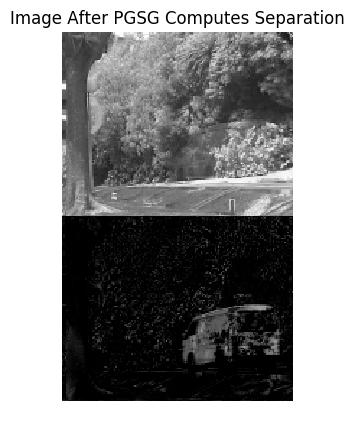

In [14]:
#Show the Separation PGSG Computed
imshow(separate(sol[1],sol[2]), cmap="gist_gray")
title("Image After PGSG Computes Separation")
axis("off");

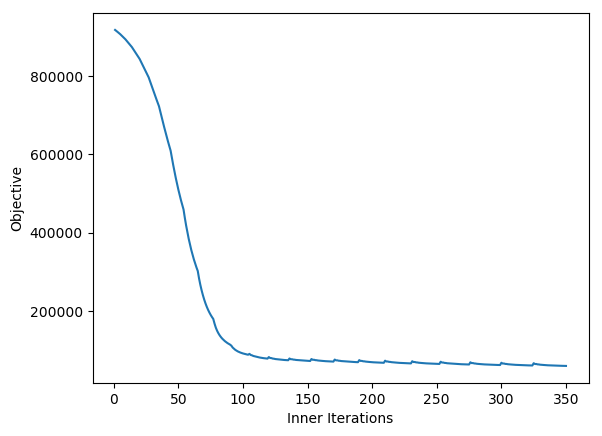

In [15]:
sol, obj_list = PGSG_objectiveTracking([U,V], 1.0, 25, oracle_RPCA, identity, obj_RPCA)

#The objective list here is in reverse order, so we will reverse it and then plot it.
obj = zeros(length(obj_list))
i=0
for val in obj_list
    obj[length(obj_list)-i] = val
    i = i+1
end    
using PyPlot
plot(1:length(obj_list), obj)
xlabel("Inner Iterations")
ylabel("Objective");

Note that one pass through the dataset gives us 102 subgradient evaluiations. Thus the above experiment takes approximately 3.5 epochs. Notably, the vast majority of the improvement in objective value comes from the first epoch.

Interestingly, the periodic "bumps" in the tail of the objective plot are caused by the inner outer loop structure of our algorithm. Each time a new inner loop begins, its step size is reset and so the first step is quite large. This causes a momentary increase in objective as it likely over shoots the optimal value.